In [1]:
import torch 
from dataloader import ECG_Data, prepare_dataset
from resnet_1d import SERes1d
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")  # Set device to GPU
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")  # Set device to CPU

CUDA is not available. Training on CPU.


In [4]:
def training_loop(model:torch.nn.Module,
                  optimizer,
                  criterion,
                  train_loader:torch.utils.data.DataLoader,
                  test_loader:torch.utils.data.DataLoader,
                  epochs:int = 100,
                  )-> tuple :
    
    losses = np.array([])
    accuracies = np.array([])
    for epoch in range(epochs):
        running_loss = 0.0
        train_acc = 0.0
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = criterion(out, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(torch.sigmoid(out).argmax(dim=1) == label)
            running_loss += loss.item()*data.size(0)
        accuracies = np.append(accuracies,train_acc/len(train_loader.dataset))
        losses = np.append(losses, running_loss/len(train_loader.dataset))
        print(f'Epoch:{epoch}  Loss:{losses[epoch]}, accuracy:{accuracies[epoch]}')

    return accuracies,losses
    

In [5]:
final_data=prepare_dataset(r"ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv")


    #split zrobiłem sklearnem bo po co się męczyć
ECG_train,ECG_test=train_test_split(final_data,test_size=0.2,random_state=42)

    #inaczej nie działa xd
ECG_train=ECG_train.reset_index()
ECG_test=ECG_test.reset_index()
    #tu ważne żeby podać ścieżkę do folderu z danymi, ale tylko folderu, bo potem to już się samo sklei
train_dataset=ECG_Data(ECG_train, r"ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/")
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=2)
test_dataset=ECG_Data(ECG_test, r"ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/")
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=2)

In [6]:
number_of_channels=12
number_of_classes=6
model = SERes1d(number_of_channels,number_of_classes).to(device)

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
number_of_epochs = 50

In [8]:
accuracies,losses = training_loop(model,optimizer,criterion,train_loader,test_loader,number_of_epochs)

Epoch:0  Loss:1.066969942955946, accuracy:0.6116694211959839
Epoch:1  Loss:0.8745904445632362, accuracy:0.6917819976806641
Epoch:2  Loss:0.7966396548418742, accuracy:0.7191178798675537
Epoch:3  Loss:0.7453855172435909, accuracy:0.7342789769172668
Epoch:4  Loss:0.7059002085530307, accuracy:0.7498420476913452
Epoch:5  Loss:0.6672186679585458, accuracy:0.761959433555603
Epoch:6  Loss:0.632928010638057, accuracy:0.77390456199646
Epoch:7  Loss:0.5956807588853662, accuracy:0.7869408130645752
Epoch:8  Loss:0.5559692507925977, accuracy:0.7988858819007874
Epoch:9  Loss:0.51615070786774, accuracy:0.8130707144737244
Epoch:10  Loss:0.47015837561730445, accuracy:0.8302417993545532
Epoch:11  Loss:0.4237027380446265, accuracy:0.8483891487121582
Epoch:12  Loss:0.3669915474107935, accuracy:0.8691207766532898
Epoch:13  Loss:0.31890383802526395, accuracy:0.8869810104370117
Epoch:14  Loss:0.2841199423570557, accuracy:0.8997300863265991
Epoch:15  Loss:0.24948218890141757, accuracy:0.9120197296142578
Epoch:

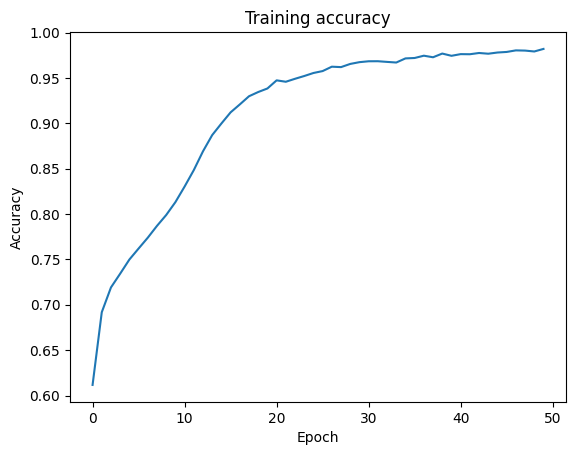

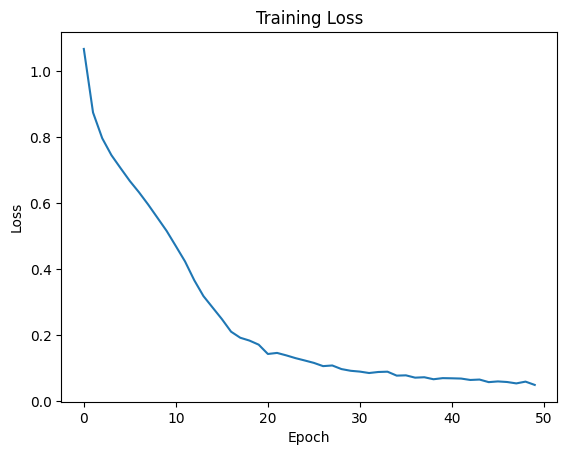

In [9]:
plt.plot(accuracies)
plt.title("Training accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()
plt.plot(losses)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [10]:
model.eval()
accuracy = 0
for data,label in test_loader :
    out = model(data)
    accuracy += torch.sum(torch.sigmoid(out).argmax(dim=1) == label)

accuracy = accuracy/ len(test_loader.dataset)
print(accuracy)

tensor(0.6844)
